# Trajectory Analysis

This notebook demonstrates trajectory characterization metrics in neurospatial.

We'll cover:
1. **Turn angles** - Direction changes in movement
2. **Step lengths** - Distance traveled between consecutive positions
3. **Home range** - Core area where animal spends most time
4. **Mean square displacement (MSD)** - Diffusion classification

**Estimated time**: 10-15 minutes

## References

- **Turn angles**: Pérez-Escudero et al. (2014). *idTracker*. Nature Methods.
- **Home range**: Powell & Mitchell (2012). What is a home range? *Journal of Mammalogy*.
- **MSD**: Einstein (1905). On the movement of small particles. *Annalen der Physik*.
- **Ecology metrics**: Signer et al. (2019). Animal movement tools (amt). *Journal of Statistical Software*.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from neurospatial import Environment
from neurospatial.metrics import (
    compute_home_range,
    compute_step_lengths,
    compute_turn_angles,
    mean_square_displacement,
)

# Set random seed for reproducibility
np.random.seed(42)

## Part 1: Generate Synthetic Trajectory

We'll create a realistic foraging trajectory with:
- Random exploration phase (first 50%)
- Directed movement to goal (last 50%)

In [2]:
# Generate meandering trajectory (exploration + goal-directed)
n_samples = 500
times = np.linspace(0, 100, n_samples)  # 100 seconds at 5 Hz

# Phase 1: Random walk exploration (first 50%)
exploration_samples = n_samples // 2
theta = np.cumsum(np.random.randn(exploration_samples) * 0.3)
r = np.cumsum(np.abs(np.random.randn(exploration_samples)) * 2)
x_explore = 50 + r * np.cos(theta)
y_explore = 50 + r * np.sin(theta)

# Phase 2: Directed movement toward goal (last 50%)
goal = np.array([80.0, 80.0])
current_pos = np.array([x_explore[-1], y_explore[-1]])
directed_samples = n_samples - exploration_samples

x_directed = np.linspace(current_pos[0], goal[0], directed_samples)
y_directed = np.linspace(current_pos[1], goal[1], directed_samples)

# Add noise to directed phase
x_directed += np.random.randn(directed_samples) * 1.5
y_directed += np.random.randn(directed_samples) * 1.5

# Combine phases
positions = np.column_stack(
    [
        np.concatenate([x_explore, x_directed]),
        np.concatenate([y_explore, y_directed]),
    ]
)

# Create environment from trajectory
env = Environment.from_samples(positions, bin_size=3.0)
env.units = "cm"
env.frame = "behavior_session_1"

print(f"Environment: {env.n_bins} bins, {env.n_dims}D")
print(f"Trajectory: {n_samples} samples over {times[-1]:.1f} seconds")

Environment: 418 bins, 2D
Trajectory: 500 samples over 100.0 seconds


Visualize the trajectory with both phases:

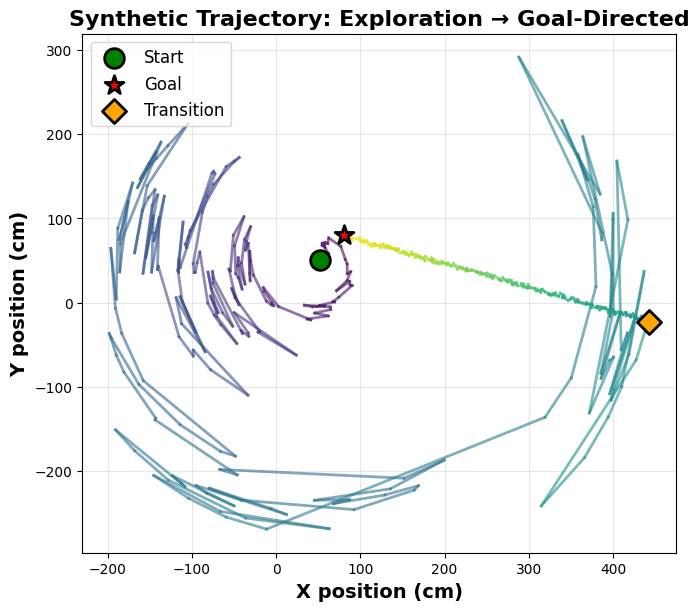

In [3]:
fig, ax = plt.subplots(figsize=(8, 6), layout="constrained")

# Plot trajectory with color gradient showing time
cmap = plt.get_cmap("viridis")
colors = cmap(np.linspace(0, 1, n_samples))
for i in range(n_samples - 1):
    ax.plot(
        positions[i : i + 2, 0],
        positions[i : i + 2, 1],
        color=colors[i],
        linewidth=2,
        alpha=0.6,
    )

# Mark start and goal
ax.scatter(
    positions[0, 0],
    positions[0, 1],
    c="green",
    s=200,
    marker="o",
    edgecolors="black",
    linewidths=2,
    label="Start",
    zorder=10,
)
ax.scatter(
    goal[0],
    goal[1],
    c="red",
    s=200,
    marker="*",
    edgecolors="black",
    linewidths=2,
    label="Goal",
    zorder=10,
)

# Mark transition point between exploration and directed
transition_idx = exploration_samples
ax.scatter(
    positions[transition_idx, 0],
    positions[transition_idx, 1],
    c="orange",
    s=150,
    marker="D",
    edgecolors="black",
    linewidths=2,
    label="Transition",
    zorder=10,
)

ax.set_xlabel("X position (cm)", fontsize=14, fontweight="bold")
ax.set_ylabel("Y position (cm)", fontsize=14, fontweight="bold")
ax.set_title(
    "Synthetic Trajectory: Exploration → Goal-Directed",
    fontsize=16,
    fontweight="bold",
)
ax.legend(fontsize=12, loc="upper left")
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)

plt.show()

## Part 2: Compute Turn Angles

**Turn angles** measure changes in movement direction between consecutive steps.

- **Formula**: Angle between velocity vectors $\vec{v}_i$ and $\vec{v}_{i+1}$
- **Range**: $[-\pi, \pi]$ radians
- **Interpretation**:
  - 0°: Straight ahead (ballistic movement)
  - ±90°: Perpendicular turn
  - ±180°: Reversal

**Use cases**:
- Identify search strategies (e.g., Lévy walks)
- Detect behavioral state changes (exploration vs exploitation)
- Quantify path tortuosity

In [4]:
# Map trajectory to bins
trajectory_bins = env.bin_at(positions)

# Compute turn angles
turn_angles = compute_turn_angles(trajectory_bins, env)

print(f"Computed {len(turn_angles)} turn angles")
print(
    f"Mean absolute turn angle: {np.abs(turn_angles).mean():.2f} rad ({np.degrees(np.abs(turn_angles).mean()):.1f}°)"
)
print(
    f"Median turn angle: {np.median(turn_angles):.2f} rad ({np.degrees(np.median(turn_angles)):.1f}°)"
)

Computed 447 turn angles
Mean absolute turn angle: 1.71 rad (97.8°)
Median turn angle: 0.00 rad (0.0°)


Visualize turn angle distribution:

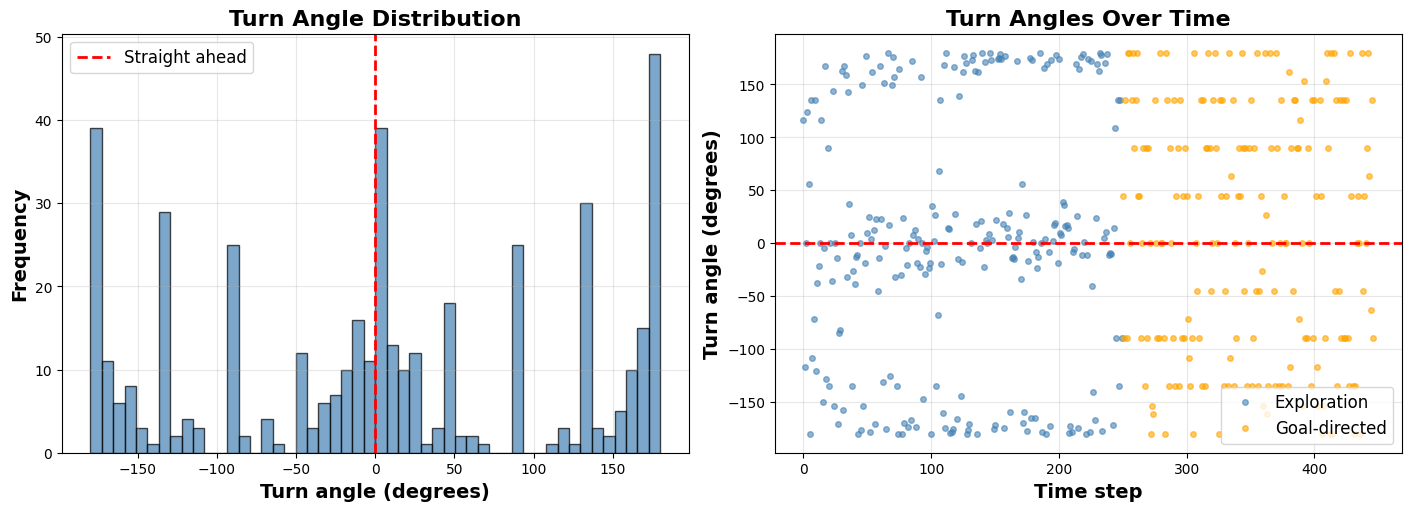

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), layout="constrained")

# Histogram
axes[0].hist(
    np.degrees(turn_angles), bins=50, color="steelblue", edgecolor="black", alpha=0.7
)
axes[0].axvline(0, color="red", linestyle="--", linewidth=2, label="Straight ahead")
axes[0].set_xlabel("Turn angle (degrees)", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Frequency", fontsize=14, fontweight="bold")
axes[0].set_title("Turn Angle Distribution", fontsize=16, fontweight="bold")
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# Time series (split by phase)
time_indices = np.arange(len(turn_angles))
explore_mask = time_indices < exploration_samples
directed_mask = time_indices >= exploration_samples

axes[1].plot(
    time_indices[explore_mask],
    np.degrees(turn_angles[explore_mask]),
    "o",
    color="steelblue",
    alpha=0.6,
    markersize=4,
    label="Exploration",
)
axes[1].plot(
    time_indices[directed_mask],
    np.degrees(turn_angles[directed_mask]),
    "o",
    color="orange",
    alpha=0.6,
    markersize=4,
    label="Goal-directed",
)
axes[1].axhline(0, color="red", linestyle="--", linewidth=2)
axes[1].set_xlabel("Time step", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Turn angle (degrees)", fontsize=14, fontweight="bold")
axes[1].set_title("Turn Angles Over Time", fontsize=16, fontweight="bold")
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.show()

**Observation**: Goal-directed phase shows smaller turn angles (straighter paths) compared to exploration phase.

## Part 3: Compute Step Lengths

**Step lengths** measure the distance traveled between consecutive positions.

- **Units**: Graph geodesic distance (bin-to-bin on connectivity graph)
- **Interpretation**:
  - Short steps: Fine-scale exploration or slow movement
  - Long steps: Ballistic movement or relocation

**Use cases**:
- Identify movement modes (Brownian vs Lévy flights)
- Detect behavioral transitions
- Compute travel distance and speed

In [6]:
# Compute step lengths (graph distances)
step_lengths = compute_step_lengths(trajectory_bins, env)

# Filter out infinite values (disconnected bins)
finite_step_lengths = step_lengths[np.isfinite(step_lengths)]

# Compute cumulative distance (use finite values)
cumulative_distance = np.concatenate([[0], np.cumsum(finite_step_lengths)])

print(f"Computed {len(step_lengths)} step lengths")
print(
    f"Finite step lengths: {len(finite_step_lengths)} ({len(finite_step_lengths) / len(step_lengths):.1%})"
)
print(f"Mean step length: {finite_step_lengths.mean():.2f} cm")
print(f"Total distance traveled: {cumulative_distance[-1]:.1f} cm")
print(
    f"Straight-line displacement: {np.linalg.norm(positions[-1] - positions[0]):.1f} cm"
)
print(
    f"Path efficiency: {np.linalg.norm(positions[-1] - positions[0]) / cumulative_distance[-1]:.2%}"
)

Computed 499 step lengths
Finite step lengths: 274 (54.9%)
Mean step length: 3.20 cm
Total distance traveled: 876.2 cm
Straight-line displacement: 39.7 cm
Path efficiency: 4.53%


Visualize step length distribution and time series:

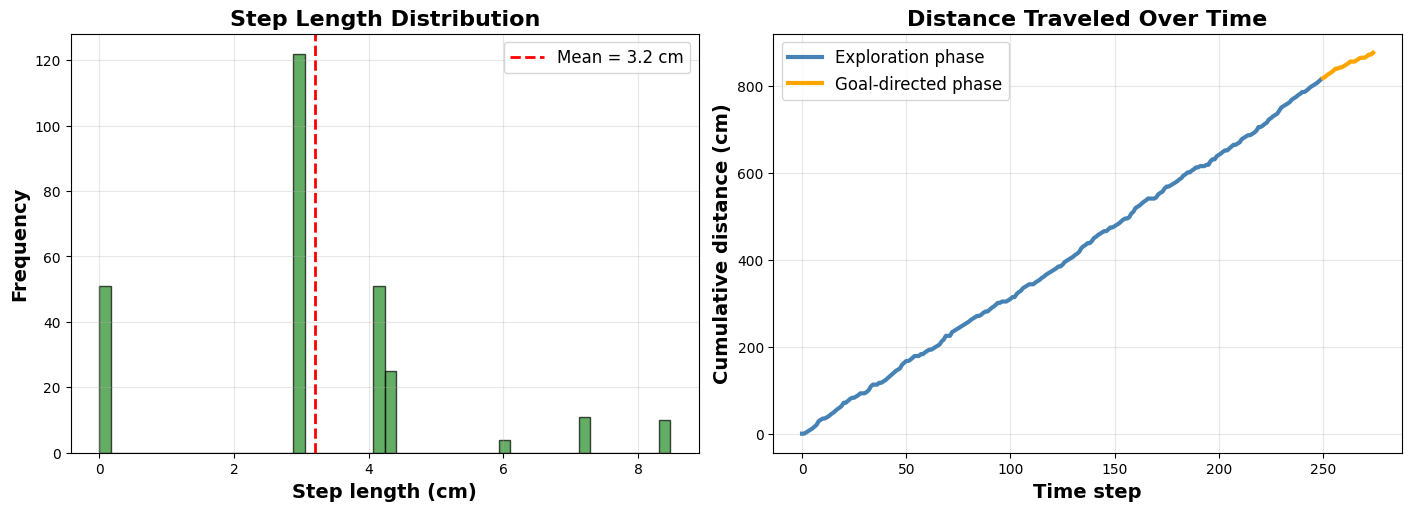

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), layout="constrained")

# Histogram (finite values only)
axes[0].hist(
    finite_step_lengths, bins=50, color="forestgreen", edgecolor="black", alpha=0.7
)
axes[0].axvline(
    finite_step_lengths.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean = {finite_step_lengths.mean():.1f} cm",
)
axes[0].set_xlabel("Step length (cm)", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Frequency", fontsize=14, fontweight="bold")
axes[0].set_title("Step Length Distribution", fontsize=16, fontweight="bold")
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# Cumulative distance
time_steps = np.arange(len(cumulative_distance))
explore_time = time_steps < exploration_samples

axes[1].plot(
    time_steps[explore_time],
    cumulative_distance[explore_time],
    color="steelblue",
    linewidth=3,
    label="Exploration phase",
)
axes[1].plot(
    time_steps[~explore_time],
    cumulative_distance[~explore_time],
    color="orange",
    linewidth=3,
    label="Goal-directed phase",
)
axes[1].set_xlabel("Time step", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Cumulative distance (cm)", fontsize=14, fontweight="bold")
axes[1].set_title("Distance Traveled Over Time", fontsize=16, fontweight="bold")
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.show()

**Observation**: Goal-directed phase shows steeper cumulative distance (faster movement toward goal).

## Part 4: Compute Home Range

**Home range** is the area where an animal spends a given percentage of its time.

- **Standard percentiles**:
  - 50%: Core area (intensive use)
  - 95%: Full home range (typical ecology standard)
  - 100%: Total area visited

- **Computation**: Based on occupancy (time spent in each bin)

**Use cases**:
- Territory size estimation
- Habitat preference analysis
- Spatial memory assessment

In [8]:
# Compute home ranges at different percentiles
core_area_50 = compute_home_range(trajectory_bins, percentile=50.0)
home_range_95 = compute_home_range(trajectory_bins, percentile=95.0)
total_area = compute_home_range(trajectory_bins, percentile=100.0)

print(f"Core area (50%): {len(core_area_50)} bins")
print(f"Home range (95%): {len(home_range_95)} bins")
print(f"Total area visited: {len(total_area)} bins")

Core area (50%): 168 bins
Home range (95%): 393 bins
Total area visited: 418 bins


Visualize home range bins on environment:

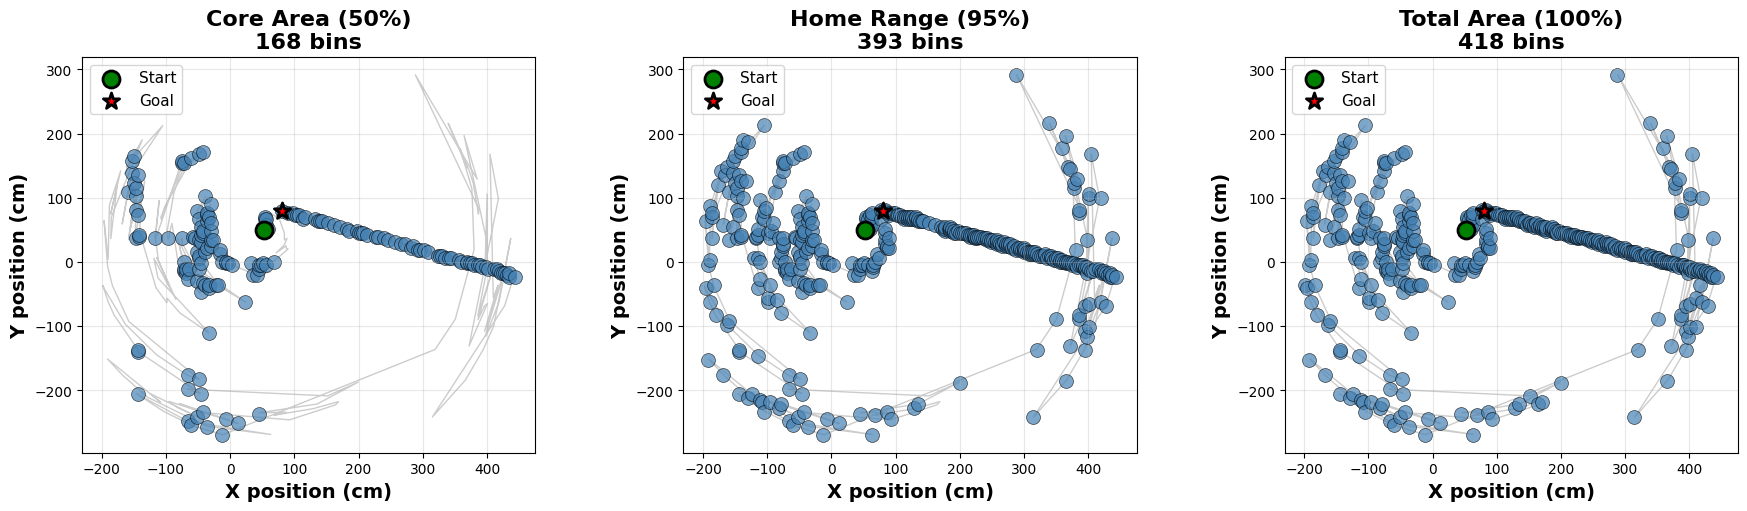

In [9]:
# Create masks for visualization
core_mask = np.zeros(env.n_bins, dtype=bool)
core_mask[core_area_50] = True

home_mask = np.zeros(env.n_bins, dtype=bool)
home_mask[home_range_95] = True

total_mask = np.zeros(env.n_bins, dtype=bool)
total_mask[total_area] = True

# Plot home ranges
fig, axes = plt.subplots(1, 3, figsize=(18, 5), layout="constrained")

for ax, mask, title, _percentile in zip(
    axes,
    [core_mask, home_mask, total_mask],
    ["Core Area (50%)", "Home Range (95%)", "Total Area (100%)"],
    [50, 95, 100],
    strict=True,
):
    # Plot bins in range
    bins_in_range = np.where(mask)[0]
    ax.scatter(
        env.bin_centers[bins_in_range, 0],
        env.bin_centers[bins_in_range, 1],
        c="steelblue",
        s=100,
        alpha=0.7,
        edgecolors="black",
        linewidths=0.5,
    )

    # Overlay trajectory
    ax.plot(
        positions[:, 0],
        positions[:, 1],
        color="gray",
        linewidth=1,
        alpha=0.4,
        zorder=0,
    )

    # Mark start and goal
    ax.scatter(
        positions[0, 0],
        positions[0, 1],
        c="green",
        s=150,
        marker="o",
        edgecolors="black",
        linewidths=2,
        label="Start",
        zorder=10,
    )
    ax.scatter(
        goal[0],
        goal[1],
        c="red",
        s=150,
        marker="*",
        edgecolors="black",
        linewidths=2,
        label="Goal",
        zorder=10,
    )

    ax.set_xlabel("X position (cm)", fontsize=14, fontweight="bold")
    ax.set_ylabel("Y position (cm)", fontsize=14, fontweight="bold")
    ax.set_title(f"{title}\n{len(bins_in_range)} bins", fontsize=16, fontweight="bold")
    ax.legend(fontsize=11, loc="upper left")
    ax.set_aspect("equal")
    ax.grid(True, alpha=0.3)

plt.show()

**Observation**: Core area (50%) concentrates around exploration region. Full home range (95%) includes path to goal.

## Part 5: Mean Square Displacement (MSD)

**MSD** characterizes diffusion properties of movement:

$$\text{MSD}(\tau) = \langle [x(t + \tau) - x(t)]^2 \rangle$$

**Power law relationship**: $\text{MSD}(\tau) \sim \tau^\alpha$

**Diffusion classification** (from MSD exponent $\alpha$):
- $\alpha < 1$: Subdiffusion (confined, territorial)
- $\alpha = 1$: Normal diffusion (random walk, Brownian motion)
- $\alpha > 1$: Superdiffusion (ballistic, directed movement)
- $\alpha = 2$: Ballistic motion (constant velocity)

**Use cases**:
- Classify movement strategies
- Detect confinement or barrier effects
- Identify directed vs random search

In [10]:
# Compute MSD for different time lags
tau_values, msd_values = mean_square_displacement(
    trajectory_bins, times, env, max_tau=30.0
)

# Fit power law: MSD ~ tau^alpha
# Use log-log fit: log(MSD) = alpha * log(tau) + const
valid_idx = (tau_values > 0) & (msd_values > 0)
log_tau = np.log(tau_values[valid_idx])
log_msd = np.log(msd_values[valid_idx])

# Linear fit in log-log space
alpha, log_const = np.polyfit(log_tau, log_msd, 1)
msd_fit = np.exp(log_const) * tau_values[valid_idx] ** alpha

print(f"MSD exponent α = {alpha:.2f}")  # noqa: RUF001  # α is scientific notation
print("\nDiffusion classification:")
if alpha < 0.9:
    print("  → Subdiffusion (confined movement)")
elif alpha < 1.1:
    print("  → Normal diffusion (random walk)")
elif alpha < 1.9:
    print("  → Superdiffusion (directed movement)")
else:
    print("  → Ballistic motion (constant velocity)")

MSD exponent α = 1.91

Diffusion classification:
  → Ballistic motion (constant velocity)


Visualize MSD curve with power law fit:

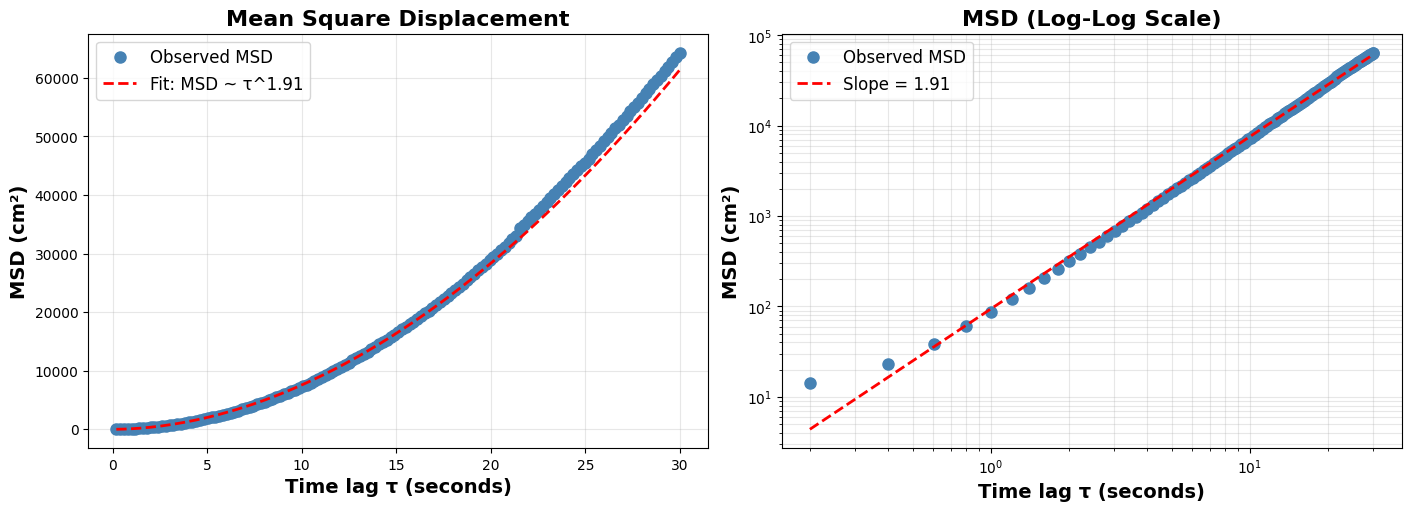

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), layout="constrained")

# MSD vs tau (linear scale)
axes[0].plot(
    tau_values, msd_values, "o", color="steelblue", markersize=8, label="Observed MSD"
)
axes[0].plot(
    tau_values[valid_idx],
    msd_fit,
    "--",
    color="red",
    linewidth=2,
    label=f"Fit: MSD ~ τ^{alpha:.2f}",
)
axes[0].set_xlabel("Time lag τ (seconds)", fontsize=14, fontweight="bold")
axes[0].set_ylabel("MSD (cm²)", fontsize=14, fontweight="bold")
axes[0].set_title("Mean Square Displacement", fontsize=16, fontweight="bold")
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# MSD vs tau (log-log scale)
axes[1].loglog(
    tau_values, msd_values, "o", color="steelblue", markersize=8, label="Observed MSD"
)
axes[1].loglog(
    tau_values[valid_idx],
    msd_fit,
    "--",
    color="red",
    linewidth=2,
    label=f"Slope = {alpha:.2f}",
)
axes[1].set_xlabel("Time lag τ (seconds)", fontsize=14, fontweight="bold")
axes[1].set_ylabel("MSD (cm²)", fontsize=14, fontweight="bold")
axes[1].set_title("MSD (Log-Log Scale)", fontsize=16, fontweight="bold")
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3, which="both")

plt.show()

**Observation**: MSD exponent α > 1 indicates superdiffusion (consistent with goal-directed movement in second phase).

## Summary

This notebook demonstrated four key trajectory metrics:

1. **Turn angles** - Quantified directional changes (straighter in goal-directed phase)
2. **Step lengths** - Measured movement distances (faster in goal-directed phase)
3. **Home range** - Identified core areas (50%, 95%, 100% occupancy)
4. **Mean square displacement** - Classified diffusion type (superdiffusion, α > 1)

### Key Takeaways

- **Turn angles and step lengths** reveal local movement properties
- **Home range** characterizes spatial coverage and territory
- **MSD exponent** classifies overall movement strategy (random vs directed)

### Next Steps

- **Behavioral segmentation**: Detect specific epochs (runs, laps, trials)
- **Trajectory similarity**: Compare paths between sessions
- **Integration with neural activity**: Correlate movement with place cell firing

See `examples/15_behavioral_segmentation.ipynb` for advanced trajectory analysis workflows.